In [2]:
%load_ext autoreload
%autoreload 2

import cv2
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("D:\\Projects\\Deep_Grasp\\deep_grasp_vgu\\deep_grasp_vgu\\deep_grasp_cnn\\src")

import ggcnn.ggcnn_torch as ggcnn_torch
from ggcnn.ggcnn_torch import predict, process_depth_image

import torch

ggcnn_torch.load_model_by_path("weights\\ggcnn_weights_cornell\\ggcnn_epoch_23_cornell")

from dougsm_helpers.gridshow import gridshow

Loading model from: weights\ggcnn_weights_cornell\ggcnn_epoch_23_cornell


D:\miniconda3\envs\yolox-build\lib\site-packages\torch\serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
D:\miniconda3\envs\yolox-build\lib\site-packages\torch\serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [31]:
!dir self_data | findstr color

12-Sep-22  04:47 PM         1,229,072 pcd0100d.tiff
12-Sep-22  04:47 PM         1,229,072 pcd0101d.tiff
12-Sep-22  04:47 PM         1,229,072 pcd0102d.tiff
12-Sep-22  04:47 PM         1,229,072 pcd0103d.tiff
12-Sep-22  04:47 PM         1,229,072 pcd0104d.tiff
12-Sep-22  04:47 PM         1,229,072 pcd0105d.tiff


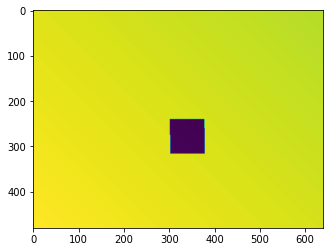

In [17]:
suff = "self_data\\1662964643" + "_"

cam_fov = 60

depth = np.load(suff + "depth.npy")
camera_rot = np.load(suff + "camera_rot.npy")
cam_K = np.load(suff + "cam_K.npy")
cam_p = np.load(suff + "cam_p.npy")
plt.imshow(depth)

### Preprocess image

In [18]:
process_depth=True
crop_size=400
out_size=300
depth_nan_mask=None
crop_y_offset=0
filters=(2.0, 1.0, 1.0)

In [19]:
depth_crop, depth_nan_mask = process_depth_image(depth, crop_size, out_size=out_size, return_mask=True, crop_y_offset=crop_y_offset)

1: 0.0ms
2: 0.4ms
3: 0.0ms
4: 0.0ms
  Inpainting: 0.0ms
5: 1.0ms
6: 0.0ms


In [20]:
points, angle, width_img, _ = predict(depth_crop, process_depth=False, depth_nan_mask=depth_nan_mask, filters=(2.0, 2.0, 2.0))

In [21]:
# Mask Points Here
angle -= np.arcsin(camera_rot[0, 1])  # Correct for the rotation of the camera
angle = (angle + np.pi/2) % np.pi - np.pi/2  # Wrap [-np.pi/2, np.pi/2]

In [22]:
# Convert to 3D positions.
imh, imw = depth.shape
x = ((np.vstack((np.linspace((imw - crop_size) // 2, (imw - crop_size) // 2 + crop_size, depth_crop.shape[1], np.float), )*depth_crop.shape[0]) - cam_K[0, 2])/cam_K[0, 0] * depth_crop).flatten()
y = ((np.vstack((np.linspace((imh - crop_size) // 2 - crop_y_offset, (imh - crop_size) // 2 + crop_size - crop_y_offset, depth_crop.shape[0], np.float), )*depth_crop.shape[1]).T - cam_K[1,2])/ cam_K[1, 1] * depth_crop).flatten()
pos = np.dot(camera_rot, np.stack((x, y, depth_crop.flatten()))).T + np.array([[cam_p[0], cam_p[1], cam_p[2]]])

width_m = width_img / 300.0 * 2.0 * depth_crop * np.tan(cam_fov * crop_size/depth.shape[0] / 2.0 / 180.0 * np.pi)

best_g = np.argmax(points)
best_g_unr = np.unravel_index(best_g, points.shape)

D:\miniconda3\envs\yolox-build\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
D:\miniconda3\envs\yolox-build\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the c

In [23]:
## Extract grasp information
grasp_x = pos[best_g, 0]
grasp_y = pos[best_g, 1]
grasp_z = pos[best_g, 2]
grasp_orientation_x = np.pi
grasp_orientation_y = 0
grasp_orientation_z = (angle[best_g_unr]%np.pi) - np.pi/2
grasp_width = width_m[best_g_unr]
grasp_quality = points[best_g_unr]

In [24]:
depth_crop_ = (depth_crop - depth_crop.min())/(depth_crop.max() - depth_crop.min())

In [25]:
depth_crop_[best_g_unr] = 1

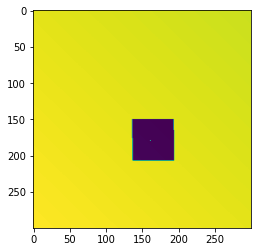

In [26]:
plt.imshow(depth_crop_)

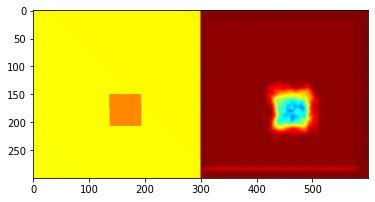

In [27]:
show = gridshow('Display',
            [depth_crop, points],
            [(0.2, 0.55), None, (-np.pi/2, np.pi/2)],
            [cv2.COLORMAP_JET, cv2.COLORMAP_JET, cv2.COLORMAP_BONE],
            3,
            False)
plt.imshow(show)

In [31]:
depth_crop

array([[0.99968135, 0.9996828 , 0.99968135, ..., 0.9991335 , 0.9991322 ,
        0.9991335 ],
       [0.9996805 , 0.99968195, 0.9996805 , ..., 0.9991327 , 0.99913144,
        0.9991327 ],
       [0.99968135, 0.9996828 , 0.99968135, ..., 0.9991335 , 0.9991322 ,
        0.9991335 ],
       ...,
       [0.99999785, 0.9999993 , 0.99999785, ..., 0.99944973, 0.9994483 ,
        0.99944973],
       [0.9999986 , 1.        , 0.9999986 , ..., 0.99945045, 0.999449  ,
        0.99945045],
       [0.99999785, 0.9999993 , 0.99999785, ..., 0.99944973, 0.9994483 ,
        0.99944973]], dtype=float32)

In [32]:
depth_crop.min(), depth_crop.max()

(0.8248369, 1.0)

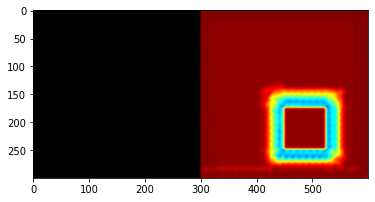

In [14]:
disp_im = cv2.imread("display.png")
plt.imshow(disp_im)

In [24]:
depth_crop

array([[0.22497667, 0.22497627, 0.22497587, ..., 0.22485368, 0.22485328,
        0.22485287],
       [0.22497691, 0.22497651, 0.22497612, ..., 0.22485393, 0.22485352,
        0.22485311],
       [0.22497717, 0.22497676, 0.22497636, ..., 0.22485416, 0.22485375,
        0.22485334],
       ...,
       [0.22504772, 0.22504732, 0.2250469 , ..., 0.22492465, 0.22492427,
        0.22492385],
       [0.22504795, 0.22504754, 0.22504714, ..., 0.22492489, 0.22492449,
        0.22492409],
       [0.22504818, 0.22504777, 0.22504736, ..., 0.22492513, 0.22492473,
        0.22492431]], dtype=float32)

In [17]:
angle.shape

(300, 300)